# Arabic dataset
we used kaggle platform to run this notebook

## Import required libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mentalhealth-ar/final_data_ar.csv


In [2]:
!pip install Tashaphyne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.5/251.5 kB 463.5 kB/s eta 0:00:00


In [3]:
import pandas as pd 
import nltk 
import re

import seaborn as sns

import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

from nltk.stem.snowball import SnowballStemmer, ArabicStemmer
from tashaphyne.stemming import ArabicLightStemmer

from warnings import filterwarnings
filterwarnings("ignore")

#### Helper Funs 

In [4]:
def get_stemming(word):
    arabic_stemming = ArabicLightStemmer()
    return (
        arabic_stemming.light_stem(word),
        arabic_stemming.get_stem(),
        arabic_stemming.get_root(),
        arabic_stemming.get_prefix(),
        arabic_stemming.get_suffix(),
        arabic_stemming.get_affix()
    )

def normalize_text(text):
    """
        this function used to convert all letter to standar ones 
        
    """
    
    return text # due to all the given text is translated from google translate we don't need to  normalize
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى" , "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة" , "ه", text)
    text = re.sub("[ًٌٍَُِّ]", "", text)
    return text

def basic_cleaning(text):
    """
        this function used to perform the basic cleaning steps like 
            1. remove digit 
            2. remove repeated words 
            3. remove emojis 
            4. remove hashtage and 
        
    """
    
    #the stemmer requires a language parameter
    text =  " ".join([ snow_stemmer.stem(word) for word in text.split()])
    text = normalize_text(text)
    # use the Ascii code to detect arabic letters only 
    text = re.sub(r'[^0-9\u0600-\u06ff\u0750-\u077f\ufb50-\ufbc1\ufbd3-\ufd3f\ufd50-\ufd8f\ufd50-\ufd8f\ufe70-\ufefc\uFDF0-\uFDFD]+', ' ', text)
    # remove digits 
    text = re.sub("[0-9]+", "", text)
    text = re.sub("[#@$%^&*!.,’/،ـ÷×٪؛<>؟~]", "", text)
    # stemmer      
    text = " ".join([get_stemming(word)[1] for word in text.split()])
    
    text = " ".join([ word for word in text.split() if not (word in arb_stopwords or word in normalized_arb_stopwords)])
    return text

## Load dataset

In [5]:
df = pd.read_csv("../input/mentalhealth-ar/final_data_ar.csv")

In [6]:
df.rename(columns= {"arabic_class": "class", "arabic_text": "text"}, inplace=True)
df = df[["text", "class"]]

### Preprocessing the data

In [7]:

#the stemmer requires a language parameter
snow_stemmer = SnowballStemmer(language='arabic')

arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))
normalized_arb_stopwords = [normalize_text(sw) for sw in arb_stopwords]

In [8]:
df["clean_text"] = df["text"].apply(basic_cleaning)

In [9]:
df[["text", "clean_text", "class"]]

,text,clean_text,class
0,RTmaideeeni: أريد أن أقول شكراً جزيلاً لكل فرد...,ريد قول شكر جزيل رد واصل قط تاكد نن موافق,القلق
1,تضمين التغريدة أنا فقط بحاجة إلى 320! شكرا على...,ضم غريد قط حاج لى شكر رص,وحيد
2,SAD_istfied سأبكي / نقاط البيع,ساب قاط يع,ضغط عصبى
3,RTJoshOfficial___: أحتاج إلى رفيق اللعنة الثابت,حتاج لى رفيق ثا,القلق
4,RTmikegolicjr: سعيد لأننا نتحدث أخيرًا عن Desh...,سعيد ان تحدث خير صو عال ان,عادي
...,...,...,...
39761,أنا متوتر الرماد لأطير من خلاله,متوتر رماد طير خلال,القلق
39762,64E7B6DA: معرف المعركة\r\nأحتاج نسخة احتياطية!...,معرف معر حتاج سخ احتياط مستوى غريمنير,وحيد
39763,الكثير من المرح ثلج الكتابة عن أيام الثلج لدين...,ثير مرح ثلج تاب يام ثلج لد وم مدهش تاب مشار رك...,القلق
39764,حساسة جدا للوقت. أنا ترانس واكتشف زملائي في ال...,حساس جد قت ترانس كتشف زملاء غرف مر وم طرد شق ح...,القلق


### Feature extraction 

In [10]:
# import required libraries for this step
from sklearn import preprocessing, model_selection, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import decomposition, ensemble



from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


from sklearn.pipeline import make_pipeline

In [11]:
# encode the target variable
encoder = preprocessing.LabelEncoder()
num_class = len(np.unique(df["class"].values))
df['class'] = encoder.fit_transform(df['class'])
# the following is the data after encoding
df['class'].value_counts()

0    12585
2    10022
1     8599
3     8560
Name: class, dtype: int64

In [12]:
# split the features and the labels
X = df['clean_text'].values.astype("U")
Y = df['class'].values.astype("U")

In [13]:
# split the data into training and testing parts
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(X, Y, test_size= 0.25,stratify= Y)

In [14]:
# Feature Engineering
cv = CountVectorizer()
cv.fit_transform(X)
cv_xtrain =  cv.transform(Xtrain)
cv_xtest =  cv.transform(Xtest)


# The following is word-level TF-IDF
tv = TfidfVectorizer()
tv.fit_transform(X)

# Transform the training and validation data using TF-IDF object
tv_xtrain =  tv.transform(Xtrain)
tv_xtest =  tv.transform(Xtest)

## Machine Learning models

In [15]:
def build(model_initializer, independent_variables_training, target, independent_variable_test):
    # fit
    model_initializer.fit(independent_variables_training, target)
    # predict
    modelPred = model_initializer.predict(independent_variable_test)
    print(classification_report(Ytest, modelPred))
    return metrics.accuracy_score(modelPred, Ytest)

In [16]:
models_results = []

In [17]:
output = build(naive_bayes.MultinomialNB(), cv_xtrain, Ytrain, cv_xtest)
print(f"count vector : {output}")
models_results.append({"model": "naive bayes count Vector", "result": output})
output = build(naive_bayes.MultinomialNB(), tv_xtrain, Ytrain, tv_xtest)
print(f"tfidf vector : {output}")
models_results.append({"model": "naive bayes tfidf vector", "result": output})

              precision    recall  f1-score   support

           0       0.64      0.65      0.65      3146
           1       0.77      0.78      0.77      2150
           2       0.66      0.57      0.61      2506
           3       0.55      0.61      0.58      2140

    accuracy                           0.65      9942
   macro avg       0.65      0.65      0.65      9942
weighted avg       0.65      0.65      0.65      9942

count vector : 0.6503721585194125
              precision    recall  f1-score   support

           0       0.54      0.78      0.64      3146
           1       0.81      0.70      0.75      2150
           2       0.65      0.52      0.57      2506
           3       0.59      0.44      0.50      2140

    accuracy                           0.62      9942
   macro avg       0.65      0.61      0.62      9942
weighted avg       0.64      0.62      0.62      9942

tfidf vector : 0.6202977268155301


In [18]:
#for cv
output = build(svm.SVC(), cv_xtrain, Ytrain, cv_xtest)
print(f"count vector: {output}")
models_results.append({"model": "SVC count Vector", "result": output})
#for TF-IDF
output = build(svm.SVC(), tv_xtrain, Ytrain, tv_xtest)
print(f"tfidf vector : {output}")
models_results.append({"model": "SVC tfidf vector", "result": output})

              precision    recall  f1-score   support

           0       0.78      0.67      0.72      3146
           1       0.94      0.85      0.89      2150
           2       0.78      0.88      0.83      2506
           3       0.63      0.73      0.68      2140

    accuracy                           0.77      9942
   macro avg       0.78      0.78      0.78      9942
weighted avg       0.78      0.77      0.77      9942

count vector: 0.7740897203781936
              precision    recall  f1-score   support

           0       0.76      0.67      0.71      3146
           1       0.94      0.86      0.90      2150
           2       0.78      0.89      0.83      2506
           3       0.63      0.69      0.66      2140

    accuracy                           0.77      9942
   macro avg       0.78      0.78      0.77      9942
weighted avg       0.78      0.77      0.77      9942

tfidf vector : 0.7700663850331925


In [19]:
# for CV
output = build(linear_model.LogisticRegression(), cv_xtrain, Ytrain, cv_xtest)
print(f"count vector: {output}")
models_results.append({"model": "Logistic Regression count Vector", "result": output})
# for TF-IDF
output = build(linear_model.LogisticRegression(), tv_xtrain, Ytrain, tv_xtest)

print(f"tfidf vector : {output}")
models_results.append({"model": "Logistic Regression tfidf vector", "result": output})

              precision    recall  f1-score   support

           0       0.75      0.67      0.71      3146
           1       0.90      0.85      0.88      2150
           2       0.77      0.85      0.81      2506
           3       0.61      0.65      0.63      2140

    accuracy                           0.75      9942
   macro avg       0.76      0.76      0.76      9942
weighted avg       0.76      0.75      0.75      9942

count vector: 0.7528666264333133
              precision    recall  f1-score   support

           0       0.75      0.68      0.71      3146
           1       0.91      0.83      0.87      2150
           2       0.72      0.85      0.78      2506
           3       0.62      0.61      0.61      2140

    accuracy                           0.74      9942
   macro avg       0.75      0.74      0.74      9942
weighted avg       0.75      0.74      0.74      9942

tfidf vector : 0.7420036210018105


In [20]:
#for CV
output = build(ensemble.RandomForestClassifier(), cv_xtrain, Ytrain, cv_xtest)
print(f"count vector: {output}")
models_results.append({"model": "Random Forest count vector", "result": output})
#for TF-IDF
output = build(ensemble.RandomForestClassifier(), tv_xtrain, Ytrain, tv_xtest)
print(f"tfidf vector : {output}")
models_results.append({"model": "Random Forest tfidf vector", "result": output})

              precision    recall  f1-score   support

           0       0.75      0.67      0.71      3146
           1       0.94      0.88      0.91      2150
           2       0.79      0.90      0.84      2506
           3       0.63      0.68      0.66      2140

    accuracy                           0.77      9942
   macro avg       0.78      0.78      0.78      9942
weighted avg       0.78      0.77      0.77      9942

count vector: 0.7741903037618185
              precision    recall  f1-score   support

           0       0.75      0.68      0.71      3146
           1       0.95      0.89      0.92      2150
           2       0.81      0.91      0.85      2506
           3       0.64      0.68      0.66      2140

    accuracy                           0.78      9942
   macro avg       0.79      0.79      0.79      9942
weighted avg       0.78      0.78      0.78      9942

tfidf vector : 0.7806276403138201


In [21]:
classifier = ensemble.RandomForestClassifier().fit(tv_xtrain, Ytrain)
val_predictions = classifier.predict(tv_xtest)
# Precision , Recall , F1 - score , Support
y_true, y_pred = Ytest, val_predictions
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.74      0.68      0.71      3146
           1       0.95      0.89      0.92      2150
           2       0.81      0.90      0.85      2506
           3       0.64      0.67      0.65      2140

    accuracy                           0.78      9942
   macro avg       0.78      0.78      0.78      9942
weighted avg       0.78      0.78      0.78      9942



## Deep Learning models
### Import required libraries

In [22]:
import nltk 
import re

from nltk.stem.snowball import SnowballStemmer, ArabicStemmer
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
import gensim
from gensim.models import KeyedVectors
from gensim.models import word2vec

# stemming 
from tashaphyne.stemming import ArabicLightStemmer

from wordcloud import WordCloud, STOPWORDS



import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten, Conv1D, MaxPooling1D, GRU
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import layers

from sklearn.metrics import accuracy_score

In [23]:
MAX_LENGTH= 200
text_tok = Tokenizer()
text_tok.fit_on_texts(df['clean_text'])
clean_text = text_tok.texts_to_sequences(df['clean_text'])
#padding
X = pad_sequences( clean_text, maxlen= MAX_LENGTH)

In [24]:
num_words = len(list(text_tok.word_index))
vocab_size = num_words + 1 

In [25]:
#train test split
indepentent_features_build, indepentent_features_valid, depentent_feature_build, depentent_feature_valid = train_test_split(X, df["class"], test_size=0.2, random_state=1) #train 80, test 20
print(indepentent_features_build.shape)
print(indepentent_features_valid.shape)
print(depentent_feature_build.shape)
print(depentent_feature_valid.shape)


(31812, 200)
(7954, 200)
(31812,)
(7954,)


In [26]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Trail 1

In [27]:
model1 = Sequential()
model1.add(Embedding(vocab_size, 100, input_length=X.shape[1]))
model1.add(GRU(265, return_sequences=True))
model1.add(GRU(128))

model1.add(Dense(2500, activation='relu'))
model1.add(Dense(2000, activation='relu'))
model1.add(Dense(1000, activation='relu'))

model1.add(Dense(4, activation='softmax'))
model1.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

print(model1.summary())

2022-10-30 18:37:58.524888: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          914800    
_________________________________________________________________
gru (GRU)                    (None, 200, 265)          291765    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               151680    
_________________________________________________________________
dense (Dense)                (None, 2500)              322500    
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              5002000   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 4

In [28]:
filepath="output_ANN.hdf5"
x = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#fir the model
history1 = model1.fit([indepentent_features_build], batch_size=64,
            y= depentent_feature_build, verbose=1, validation_split=0.25, shuffle=True, 
            epochs=50, callbacks=[x, earlyStoppingCallback])

Epoch 1/50


2022-10-30 18:37:59.322766: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


373/373 [==============================] - 395s 1s/step - loss: 0.8192 - accuracy: 0.6534 - val_loss: 0.6904 - val_accuracy: 0.7302
Epoch 2/50
373/373 [==============================] - 388s 1s/step - loss: 0.5500 - accuracy: 0.7782 - val_loss: 0.6078 - val_accuracy: 0.7498
Epoch 3/50
373/373 [==============================] - 389s 1s/step - loss: 0.4561 - accuracy: 0.8105 - val_loss: 0.6714 - val_accuracy: 0.7548
Epoch 4/50
373/373 [==============================] - 386s 1s/step - loss: 0.3907 - accuracy: 0.8349 - val_loss: 0.6322 - val_accuracy: 0.7569
Epoch 5/50
373/373 [==============================] - 385s 1s/step - loss: 0.3391 - accuracy: 0.8517 - val_loss: 0.6916 - val_accuracy: 0.7546
Epoch 6/50
373/373 [==============================] - 388s 1s/step - loss: 0.3078 - accuracy: 0.8644 - val_loss: 0.7533 - val_accuracy: 0.7471
Epoch 7/50
373/373 [==============================] - 393s 1s/step - loss: 0.2837 - accuracy: 0.8717 - val_loss: 0.8191 - val_accuracy: 0.7527


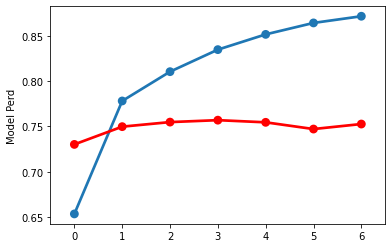

In [29]:
dfaccuracy = pd.DataFrame({ 'Model hist': history1.history['accuracy'], 
                           'Model Perd': history1.history['val_accuracy']})
#line for train accuracy
g = sns.pointplot(x= dfaccuracy.index, y="Model hist", data=dfaccuracy, fit_reg=False)
#line for test
g = sns.pointplot(x=dfaccuracy.index, y="Model Perd", data=dfaccuracy, fit_reg=False, color='Red')

In [30]:
accr1 = model1.evaluate(indepentent_features_valid, depentent_feature_valid)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr1[0],accr1[1]))
models_results.append({"model": "GRU", "result": accr1[1]})

249/249 [==============================] - 55s 216ms/step - loss: 0.8350 - accuracy: 0.7475
Test set
  Loss: 0.835
  Accuracy: 0.748


### Trial 2

In [31]:
model2= Sequential()
model2.add(Embedding(vocab_size,100, input_length = MAX_LENGTH))
model2.add(Flatten())
model2.add(Dense(100,name='FC1', activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_class, activation='softmax',name='out_layer'))
model2.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
print(model2.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          914800    
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
FC1 (Dense)                  (None, 100)               2000100   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
out_layer (Dense)            (None, 4)                 404       
Total params: 2,915,304
Trainable params: 2,915,304
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
filepath="output_ANN.hdf5"
x = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#fir the model
history = model2.fit([indepentent_features_build], batch_size=64,
            y= to_categorical(depentent_feature_build), verbose=1, validation_split=0.25, shuffle=True, 
            epochs=50, callbacks=[x, earlyStoppingCallback])

Epoch 1/50
373/373 [==============================] - 10s 24ms/step - loss: 0.9765 - accuracy: 0.5828 - val_loss: 0.6812 - val_accuracy: 0.7173
Epoch 2/50
373/373 [==============================] - 9s 23ms/step - loss: 0.6138 - accuracy: 0.7556 - val_loss: 0.6116 - val_accuracy: 0.7499
Epoch 3/50
373/373 [==============================] - 9s 23ms/step - loss: 0.5031 - accuracy: 0.8031 - val_loss: 0.6012 - val_accuracy: 0.7588
Epoch 4/50
373/373 [==============================] - 9s 25ms/step - loss: 0.4234 - accuracy: 0.8338 - val_loss: 0.6183 - val_accuracy: 0.7586
Epoch 5/50
373/373 [==============================] - 9s 23ms/step - loss: 0.3585 - accuracy: 0.8579 - val_loss: 0.6911 - val_accuracy: 0.7573
Epoch 6/50
373/373 [==============================] - 9s 24ms/step - loss: 0.3116 - accuracy: 0.8724 - val_loss: 0.7127 - val_accuracy: 0.7588
Epoch 7/50
373/373 [==============================] - 9s 25ms/step - loss: 0.2794 - accuracy: 0.8848 - val_loss: 0.7800 - val_accuracy: 0.751

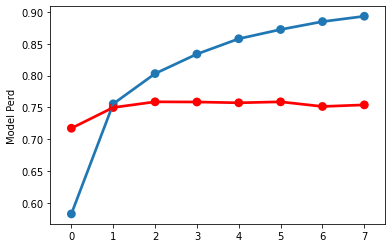

In [33]:
dfaccuracy = pd.DataFrame({ 'Model hist': history.history['accuracy'], 
                           'Model Perd': history.history['val_accuracy']})
#line for train accuracy
g = sns.pointplot(x= dfaccuracy.index, y="Model hist", data=dfaccuracy, fit_reg=False)
#line for test
g = sns.pointplot(x=dfaccuracy.index, y="Model Perd", data=dfaccuracy, fit_reg=False, color='Red')

In [34]:
accr = model2.evaluate(indepentent_features_valid, to_categorical(depentent_feature_valid))
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
models_results.append({"model": "Normal NN", "result": accr[1]})

249/249 [==============================] - 1s 4ms/step - loss: 0.8560 - accuracy: 0.7514
Test set
  Loss: 0.856
  Accuracy: 0.751


### Trail 3

In [35]:
model3= Sequential()
model3.add(Embedding(vocab_size,100, input_length = MAX_LENGTH))
model3.add(LSTM(60))
model3.add(Dense(100,name='FC1', activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(num_class, activation='softmax',name='out_layer'))
model3.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          914800    
_________________________________________________________________
lstm (LSTM)                  (None, 60)                38640     
_________________________________________________________________
FC1 (Dense)                  (None, 100)               6100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
out_layer (Dense)            (None, 4)                 404       
Total params: 959,944
Trainable params: 959,944
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
filepath="output_ANN.hdf5"
x = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#fir the model
history2 = model3.fit([indepentent_features_build], batch_size=64,
            y= depentent_feature_build, verbose=1, validation_split=0.25, shuffle=True, 
            epochs=50, callbacks=[x, earlyStoppingCallback])

Epoch 1/50
373/373 [==============================] - 90s 233ms/step - loss: 0.8484 - accuracy: 0.6413 - val_loss: 0.6606 - val_accuracy: 0.7343
Epoch 2/50
373/373 [==============================] - 86s 230ms/step - loss: 0.5962 - accuracy: 0.7623 - val_loss: 0.6139 - val_accuracy: 0.7416
Epoch 3/50
373/373 [==============================] - 87s 233ms/step - loss: 0.5310 - accuracy: 0.7885 - val_loss: 0.6038 - val_accuracy: 0.7485
Epoch 4/50
373/373 [==============================] - 100s 269ms/step - loss: 0.4958 - accuracy: 0.8010 - val_loss: 0.6000 - val_accuracy: 0.7547
Epoch 5/50
373/373 [==============================] - 97s 260ms/step - loss: 0.4676 - accuracy: 0.8117 - val_loss: 0.6246 - val_accuracy: 0.7505
Epoch 6/50
373/373 [==============================] - 94s 252ms/step - loss: 0.4361 - accuracy: 0.8223 - val_loss: 0.6120 - val_accuracy: 0.7510
Epoch 7/50
373/373 [==============================] - 85s 227ms/step - loss: 0.4125 - accuracy: 0.8308 - val_loss: 0.6424 - val_a

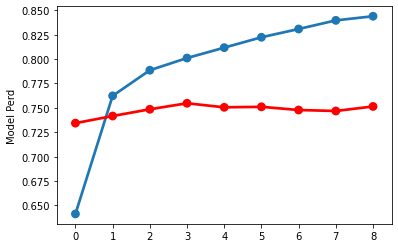

In [37]:
dfaccuracy = pd.DataFrame({ 'Model hist': history2.history['accuracy'], 
                           'Model Perd': history2.history['val_accuracy']})
#line for train accuracy
g = sns.pointplot(x= dfaccuracy.index, y="Model hist", data=dfaccuracy, fit_reg=False)
#line for test
g = sns.pointplot(x=dfaccuracy.index, y="Model Perd", data=dfaccuracy, fit_reg=False, color='Red')

In [38]:
accr = model3.evaluate(indepentent_features_valid, depentent_feature_valid)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
models_results.append({"model": "LSTM", "result": accr[1]})

249/249 [==============================] - 13s 49ms/step - loss: 0.6687 - accuracy: 0.7514
Test set
  Loss: 0.669
  Accuracy: 0.751


#### Trail 4

In [39]:
model4 = Sequential()
model4.add(Embedding(vocab_size,100, input_length = MAX_LENGTH))
model4.add(Conv1D(60, 10))
model4.add(MaxPooling1D(pool_size=2))
model4.add(LSTM(60))
model4.add(Dense(100,name='FC1', activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_class, activation='softmax',name='out_layer'))
model4.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
print(model4.summary())



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          914800    
_________________________________________________________________
conv1d (Conv1D)              (None, 191, 60)           60060     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 95, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                29040     
_________________________________________________________________
FC1 (Dense)                  (None, 100)               6100      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
out_layer (Dense)            (None, 4)                

In [40]:
filepath="output_ANN.hdf5"
x = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#fir the model
history2 = model4.fit([indepentent_features_build], batch_size=64,
            y= depentent_feature_build.values, verbose=1, validation_split=0.25, shuffle=True, 
            epochs=50, callbacks=[x, earlyStoppingCallback])

Epoch 1/50
373/373 [==============================] - 64s 164ms/step - loss: 0.8959 - accuracy: 0.6206 - val_loss: 0.7067 - val_accuracy: 0.7127
Epoch 2/50
373/373 [==============================] - 60s 161ms/step - loss: 0.6578 - accuracy: 0.7411 - val_loss: 0.6872 - val_accuracy: 0.7170
Epoch 3/50
373/373 [==============================] - 60s 162ms/step - loss: 0.5710 - accuracy: 0.7720 - val_loss: 0.6753 - val_accuracy: 0.7258
Epoch 4/50
373/373 [==============================] - 61s 162ms/step - loss: 0.4930 - accuracy: 0.8024 - val_loss: 0.6944 - val_accuracy: 0.7266
Epoch 5/50
373/373 [==============================] - 61s 164ms/step - loss: 0.4250 - accuracy: 0.8277 - val_loss: 0.7487 - val_accuracy: 0.7293
Epoch 6/50
373/373 [==============================] - 61s 164ms/step - loss: 0.3682 - accuracy: 0.8473 - val_loss: 0.7980 - val_accuracy: 0.7270
Epoch 7/50
373/373 [==============================] - 61s 163ms/step - loss: 0.3260 - accuracy: 0.8606 - val_loss: 0.9120 - val_ac

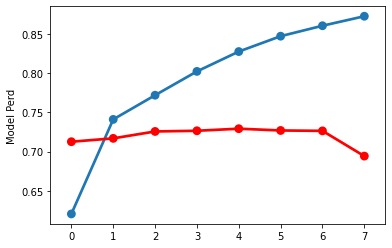

In [41]:
dfaccuracy = pd.DataFrame({ 'Model hist': history2.history['accuracy'], 
                           'Model Perd': history2.history['val_accuracy']})
#line for train accuracy
g = sns.pointplot(x= dfaccuracy.index, y="Model hist", data=dfaccuracy, fit_reg=False)
#line for test
g = sns.pointplot(x=dfaccuracy.index, y="Model Perd", data=dfaccuracy, fit_reg=False, color='Red')

In [42]:
accr = model4.evaluate(indepentent_features_valid, depentent_feature_valid)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
models_results.append({"model": "CNN", "result": accr[1]})

249/249 [==============================] - 9s 32ms/step - loss: 0.9934 - accuracy: 0.6934
Test set
  Loss: 0.993
  Accuracy: 0.693


In [43]:
results = pd.DataFrame(models_results).sort_values(by="result")


In [44]:
results["result"] = results["result"].apply(lambda x : int(x * 100))

Text(0.5, 1.0, 'Machine learning Models')

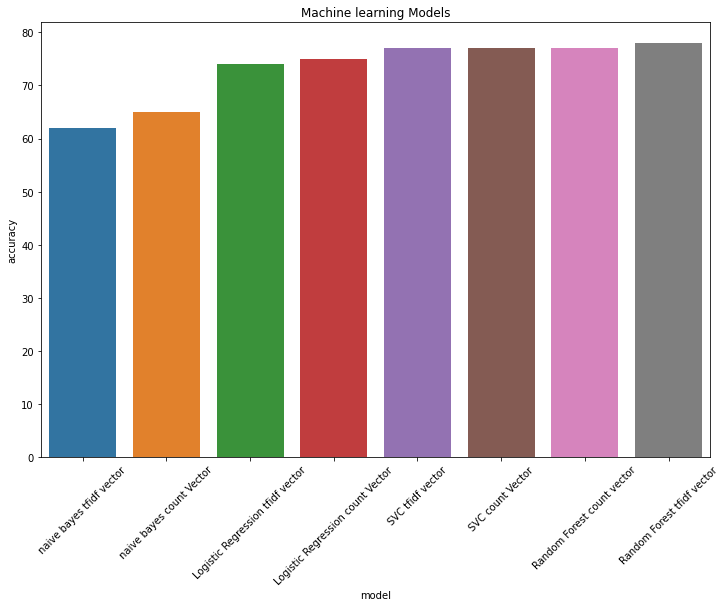

In [45]:
plt.figure(figsize= (12, 8))
sns.barplot(x="model", y= "result", data= results[results["model"].str.contains("count [v|V]ector|tfidf")])
plt.xticks(rotation = 45);
plt.xlabel("model")
plt.ylabel("accuracy")
plt.title("Machine learning Models")

Text(0.5, 1.0, 'deep learning Models')

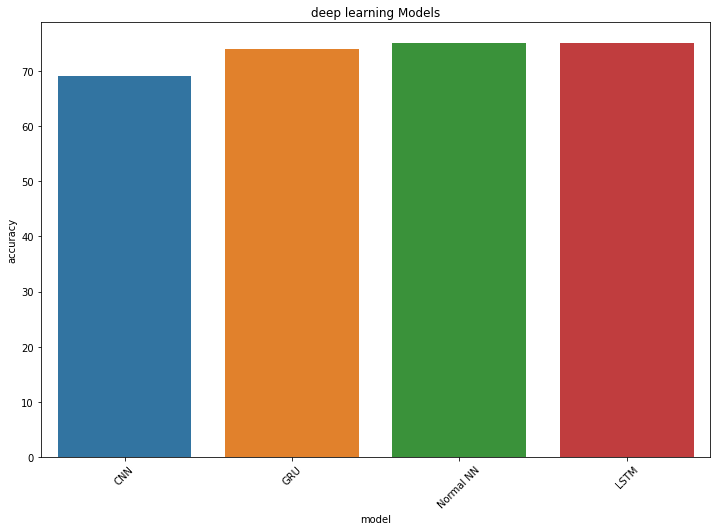

In [46]:
plt.figure(figsize= (12, 8))
sns.barplot(x="model", y= "result", data= results[~results["model"].str.contains("count [v|V]ector|tfidf")])
plt.xticks(rotation = 45);
plt.xlabel("model")
plt.ylabel("accuracy")
plt.title("deep learning Models")